In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from fbprophet import Prophet
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font', family='serif')

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [2]:
WELL_DATA_PATH_MODIFIED = os.getcwd() + '/data/well-time-series-HPA-modified/'
CSV_NAME = "400155101521302_11740_lat_40.0286666666667_lon_-101.871222222222_2019-10-19_232352_modified.csv"

data = pd.read_csv(WELL_DATA_PATH_MODIFIED + CSV_NAME)

data.index = pd.to_datetime(data["date"])
#data.info()

Text(0, 0.5, 'DTW [ft] for SiteNo: 400155101521302')

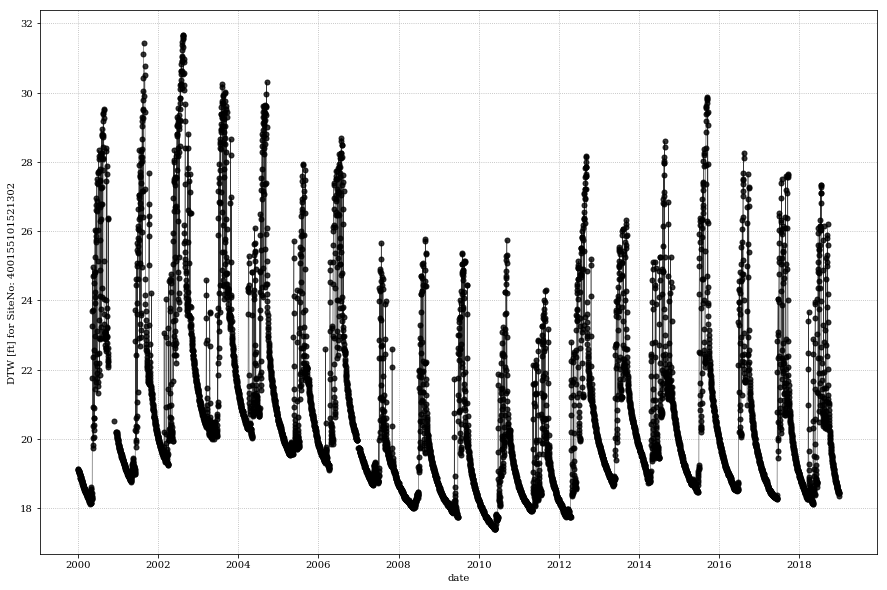

In [3]:
#plt.plot(range(data.shape[0]), data.wa_km)
plt.figure(figsize=(15,10))
fig_args = {'color':'k',
            'marker':'o',
            #'markeredgecolor':'w',
            'markersize':5,
            'linewidth':0.5,
            'alpha':0.8}
plt.plot(data.index, data.DTW_surface_ft, **fig_args)
plt.grid(linestyle='dotted')
plt.xlabel('date')
plt.ylabel('DTW [ft] for SiteNo: {}'.format(CSV_NAME.split("_")[0]))

In [4]:
"""
resampling = 'W'

data_weekly = data.resample(resampling).mean()

plt.figure(figsize=(15,10))
plt.plot(data_weekly.index, data_weekly.DTW_surface_ft, **fig_args)
plt.grid(linestyle='dotted')
plt.xlabel('date')
plt.ylabel('DTW [ft] for SiteNo: {}'.format(CSV_NAME.split("_")[0]))
"""

'\nresampling = \'W\'\n\ndata_weekly = data.resample(resampling).mean()\n\nplt.figure(figsize=(15,10))\nplt.plot(data_weekly.index, data_weekly.DTW_surface_ft, **fig_args)\nplt.grid(linestyle=\'dotted\')\nplt.xlabel(\'date\')\nplt.ylabel(\'DTW [ft] for SiteNo: {}\'.format(CSV_NAME.split("_")[0]))\n'

In [5]:
import os, sys
from math import sqrt
from numpy import concatenate
from pandas import read_csv, DataFrame, concat
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM

Using TensorFlow backend.


In [6]:
dataset = data[['DTW_surface_ft',
                'prcp (mm/day)',
                'srad (W/m^2)',
                'swe (kg/m^2)',
                'tmax (deg c)',
                'tmin (deg c)',
                'vp (Pa)',
                'number_of_wells',
                'avg_pump_rate']]

dataset.index.name = 'date'
#dataset.index = pd.to_datetime(data["date"])
dataset['DTW_surface_ft'].fillna(0, inplace=True)

/home/soroushr/projects/envs/time-series/lib/python3.6/site-packages/pandas/core/generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [7]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


In [8]:
values = dataset.values
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)

#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
to_drop = list(range(reframed.shape[1]-1,values.shape[1],-1))
reframed.drop(reframed.columns[to_drop], axis=1, inplace=True)

In [13]:
values = reframed.values
n_years = 5
n_train_days = 365 * n_years #* n_years
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X ,  test_y = test[:, :-1] , test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X  = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(1825, 1, 17) (1825,) (5109, 1, 17) (5109,)


In [14]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=1, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.grid(linestyle='dotted')
plt.savefig('zz_loss.png', dpi=300)
plt.clf()

Train on 1825 samples, validate on 5109 samples
Epoch 1/50
1825/1825 [==============================] - 1s 396us/step - loss: 0.4409 - val_loss: 0.9386
Epoch 2/50
1825/1825 [==============================] - 0s 60us/step - loss: 0.3919 - val_loss: 0.8301
Epoch 3/50
1825/1825 [==============================] - 0s 59us/step - loss: 0.3052 - val_loss: 0.6282
Epoch 4/50
1825/1825 [==============================] - 0s 62us/step - loss: 0.2365 - val_loss: 0.4212
Epoch 5/50
1825/1825 [==============================] - 0s 61us/step - loss: 0.1247 - val_loss: 0.0942
Epoch 6/50
1825/1825 [==============================] - 0s 61us/step - loss: 0.0460 - val_loss: 0.0187
Epoch 7/50
1825/1825 [==============================] - 0s 59us/step - loss: 0.0769 - val_loss: 0.0965
Epoch 8/50
1825/1825 [==============================] - 0s 58us/step - loss: 0.0550 - val_loss: 0.0478
Epoch 9/50
1825/1825 [==============================] - 0s 63us/step - loss: 0.0587 - val_loss: 0.0289
Epoch 10/50
1825/1825 [=

<Figure size 432x288 with 0 Axes>

In [15]:
# make a prediction
yhat   = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y  = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y  = scaler.inverse_transform(inv_y)
inv_y  = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

"\ntest_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))\n# invert scaling for forecast\ninv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)\ninv_yhat = scaler.inverse_transform(inv_yhat)\ninv_yhat = inv_yhat[:,0]\n# invert scaling for actual\ntest_y = test_y.reshape((len(test_y), 1))\ninv_y  = concatenate((test_y, test_X[:, 1:]), axis=1)\ninv_y  = scaler.inverse_transform(inv_y)\ninv_y  = inv_y[:,0]\n# calculate RMSE\nrmse = sqrt(mean_squared_error(inv_y, inv_yhat))\nprint('Test RMSE: %.3f' % rmse)\n"